### Importing needed libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

import os
from random import shuffle

### Reading the data

In [38]:
# read train
train= pd.read_csv("C:/Users/yaraa/Desktop/GroceryStoreDataset/dataset/train.txt")
print("training set shape: ",train.shape)
train.head()

training set shape:  (2640, 3)


,image path,Class ID,Coarse Class ID
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0


In [39]:
# read test 
test = pd.read_csv("C:/Users/yaraa/Desktop/GroceryStoreDataset/dataset/test.txt")
print("test set shape: ", test.shape)

test set shape:  (2485, 3)


In [40]:
# read validation 
val = pd.read_csv("C:/Users/yaraa/Desktop/GroceryStoreDataset/dataset/val.txt")
print("validation set shape: ", val.shape)

validation set shape:  (296, 3)


##### - The model will classify by the coarse grained classes, so the fine grained ones (class ID) are not needed

In [41]:
train.drop(['Class ID'], axis=1, inplace=True)
val.drop(['Class ID'], axis=1, inplace=True)
test.drop(['Class ID'], axis=1, inplace=True)

## Training set class distribution

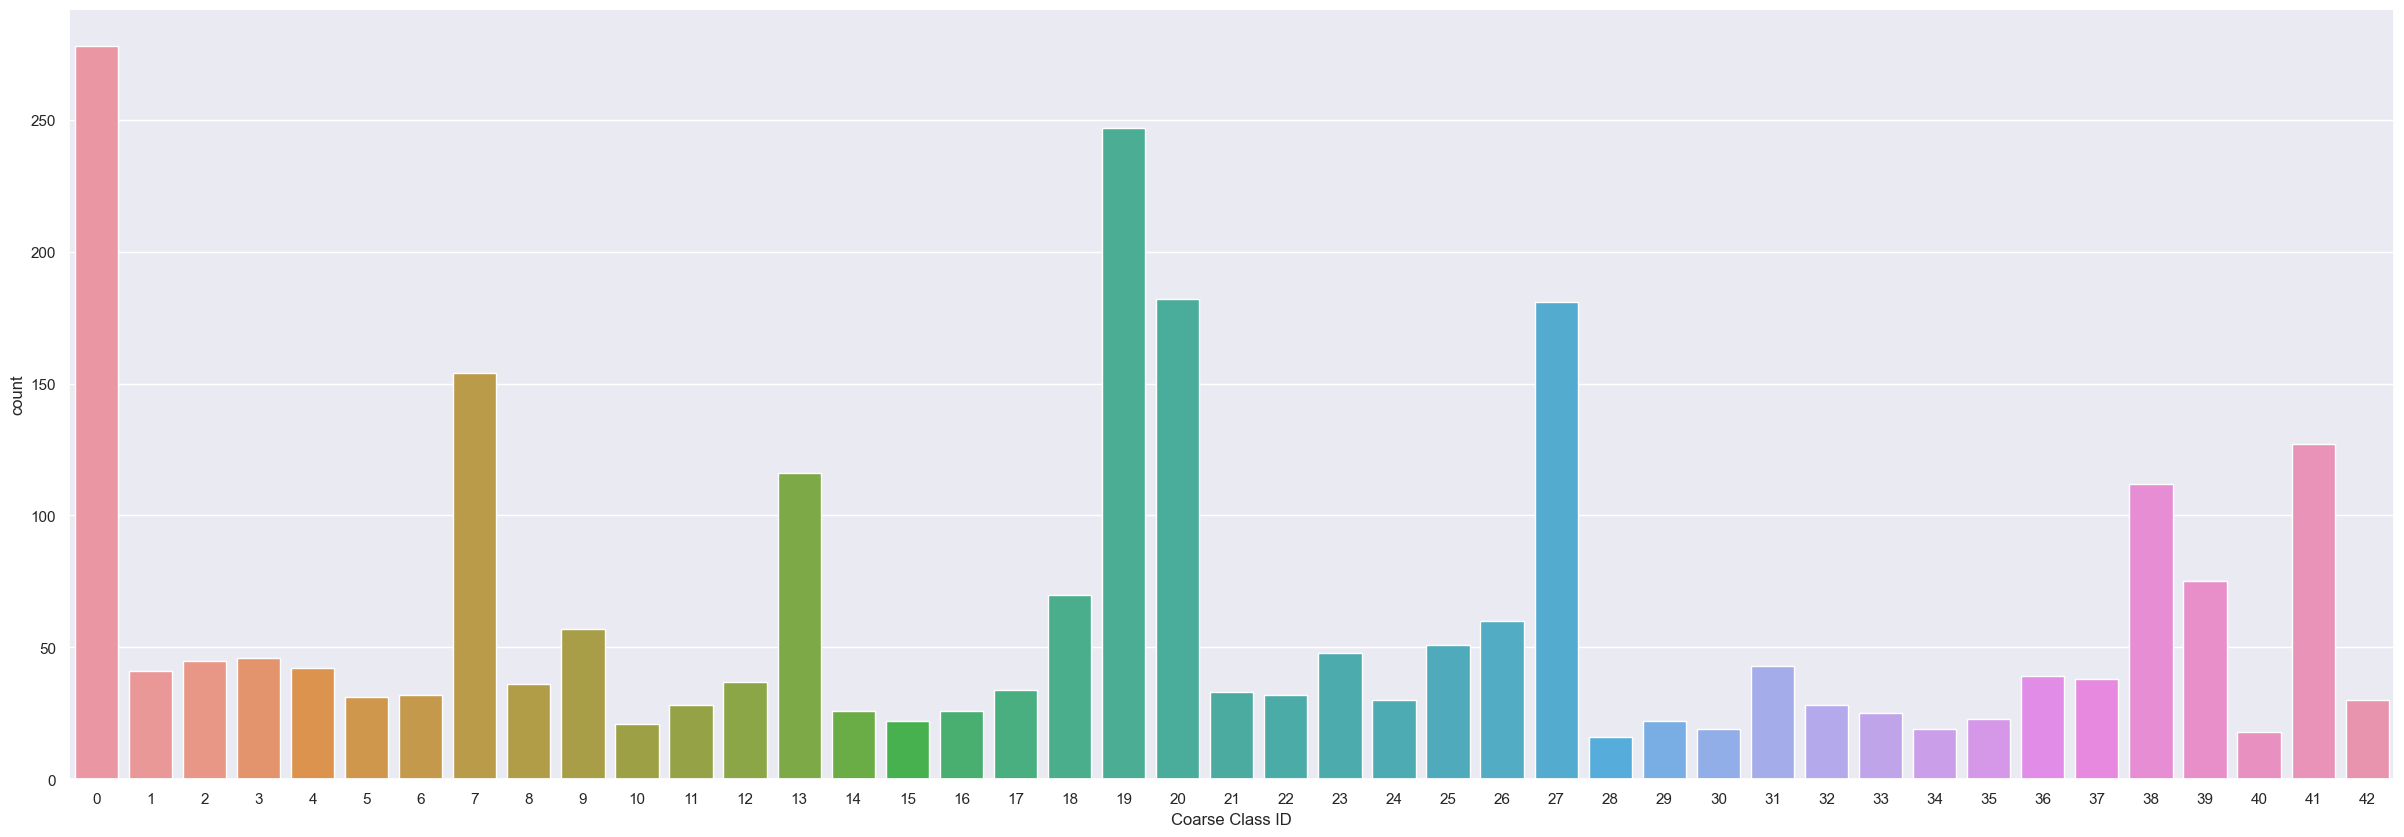

In [42]:
train_distrib = train['Coarse Class ID'].value_counts()
# Horizontal bar plot
plt.figure(figsize=(30,10))
sns.set(style="whitegrid")
sns.set(font_scale=1)
ax = sns.barplot(x = train_distrib.index, y = train_distrib)
plt.show()

#### Our training set is imbalanced

### For the features:
#### - Reading the images by the full path
#### - See the ranges for the image sizes to determine appropriate resizing value

In [43]:
# storing first part of path that is missing in the dataset
pathFirst = "C:/Users/yaraa/Desktop/GroceryStoreDataset/dataset/"

In [44]:
shapes = []
for pathSecond in train['image path']:
    # concatenating first and second half of the path
    fullPath = pathFirst + pathSecond
    image = cv2.imread(fullPath)
    shapes.append(image.shape)

In [45]:
# images dimensions
pd.Series(shapes).value_counts()

(348, 348, 3)    2497
(464, 348, 3)     126
(348, 464, 3)      17
Name: count, dtype: int64

###### - most of the images are sized 348x348 and the rest of the images have close enough size ranges
###### - images will be resized to 200x200 which is enough to reduce complexity and not cause too much information loss

In [46]:
x_train = []
for pathSecond in train['image path']:
    fullPath = pathFirst + pathSecond
    img = cv2.imread(fullPath)
    image = cv2.resize(img, (200, 200))
    x_train.append(image)

In [47]:
x_val = []
for pathSecond in val['image path']:
    fullPath = pathFirst + pathSecond
    img = cv2.imread(fullPath)
    image = cv2.resize(img, (200, 200))
    x_val.append(image)

In [48]:
x_test = []
for pathSecond in test['image path']:
    fullPath = pathFirst + pathSecond
    img = cv2.imread(fullPath)
    image = cv2.resize(img, (200, 200))
    x_test.append(image)

In [49]:
print(x_test[0].shape)

(200, 200, 3)


#### - Normalizing images

In [50]:
# normalizing training set
xtr = np.array(x_train)
x_train = xtr.astype('float32')
x_train/=255

# normalizing validation set
xvl= np.array(x_val)
x_val = xvl.astype('float32')
x_val/=255

# normalizing testing set
xts= np.array(x_test)
x_test = xts.astype('float32')
x_test/=255

In [51]:
print(x_test[0])

[[[0.03921569 0.46666667 0.54901963]
  [0.03529412 0.47058824 0.5568628 ]
  [0.03529412 0.47058824 0.5568628 ]
  ...
  [0.         0.01960784 0.00392157]
  [0.         0.03137255 0.03529412]
  [0.         0.01960784 0.04705882]]

 [[0.06666667 0.5058824  0.58431375]
  [0.0627451  0.5019608  0.5803922 ]
  [0.05098039 0.49019608 0.5764706 ]
  ...
  [0.         0.03529412 0.02745098]
  [0.         0.03137255 0.03921569]
  [0.         0.01960784 0.05098039]]

 [[0.11372549 0.5294118  0.6039216 ]
  [0.1254902  0.54901963 0.6313726 ]
  [0.10980392 0.5529412  0.6313726 ]
  ...
  [0.00392157 0.05882353 0.05490196]
  [0.         0.05490196 0.07450981]
  [0.03137255 0.04705882 0.08627451]]

 ...

 [[0.09411765 0.49019608 0.54901963]
  [0.13333334 0.57254905 0.627451  ]
  [0.11372549 0.61960787 0.6627451 ]
  ...
  [0.2509804  0.6784314  0.7882353 ]
  [0.2627451  0.6901961  0.8       ]
  [0.2509804  0.6784314  0.7882353 ]]

 [[0.07450981 0.5803922  0.6313726 ]
  [0.07058824 0.60784316 0.654902  ]


* images pixel values are now between 0 and 1, which will make the training faster

### For the target:
#### - store Coarse Class ID in a target list
#### - obtain number of classes

In [52]:
# storing labels
y_train = train["Coarse Class ID"]
y_val = val["Coarse Class ID"]
y_test = test["Coarse Class ID"]

In [53]:
# getting classnames
classNames = train["Coarse Class ID"].unique()
classesNumber = classNames.size
print("number of classes: ", classesNumber)

number of classes:  43


### Fixing the training set imbalance using SMOTE


##### Reshaping x_train from 4d to to 2d

In [54]:
x_train_reshaped = x_train.reshape(x_train.shape[0], 200*200*3)

In [55]:
print(x_train_reshaped.shape)
print(y_train.shape)

(2640, 120000)
(2640,)


###### Performing smote to increase number of samples in a balanced way

In [56]:
sm = SMOTE(random_state=42)
x_smote, y_smote = sm.fit_resample(x_train_reshaped, y_train)

In [57]:
x_smote.shape
y_smote.shape

(11954,)

In [58]:
# reshaping the samples back to their original dimensions
x_train = x_smote.reshape(x_smote.shape[0], 200, 200, 3)
x_train.shape

(11954, 200, 200, 3)

In [59]:
# converting np.array to a dataframe to be able to plot the distribution
df = pd.DataFrame({'y':y_smote})

###### Plotting new training set distribution

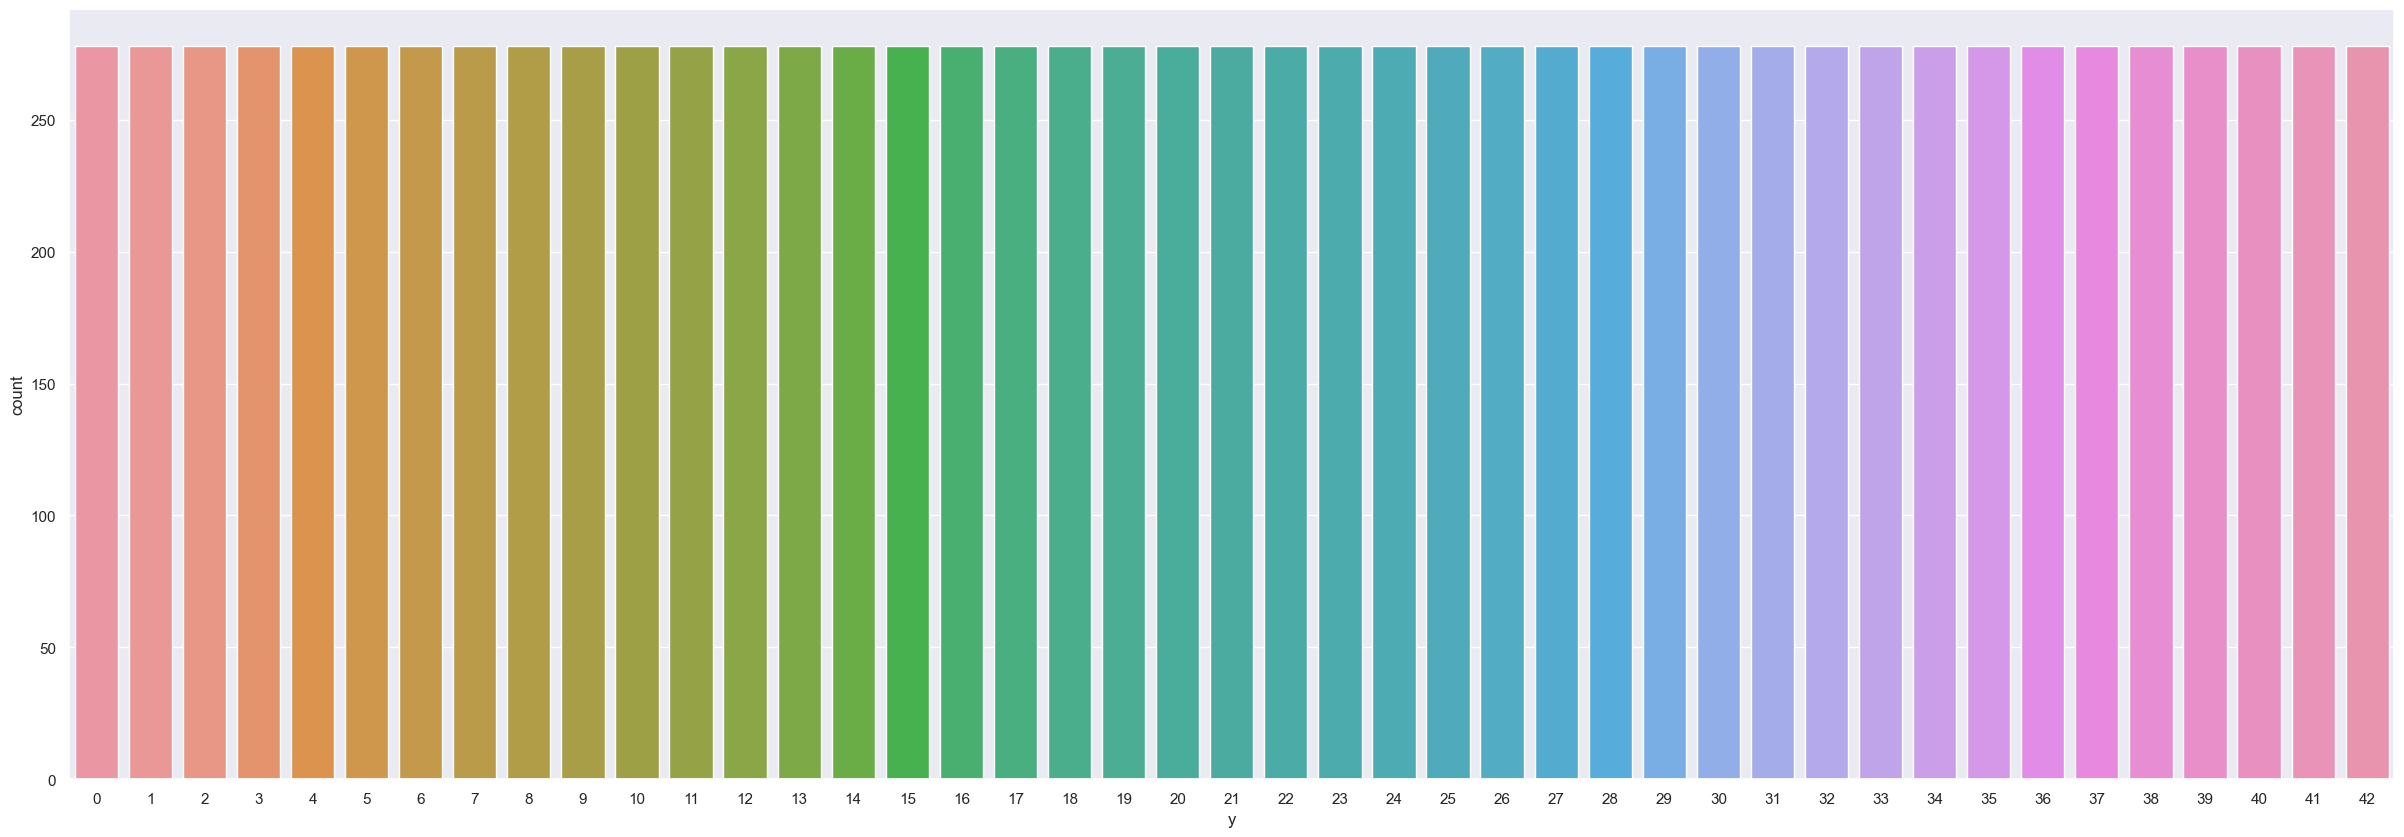

In [60]:
smote_distrib = df['y'].value_counts()
# Horizontal bar plot
plt.figure(figsize=(30,10))
sns.set(style="whitegrid")
sns.set(font_scale=1)
ax = sns.barplot(x = smote_distrib.index, y = smote_distrib)
plt.show()

#### Our training set is now balanced

### one hot encoding to target

In [61]:
# one hot encoding
y_train = to_categorical(y_smote, classesNumber)
y_val = to_categorical(y_val, classesNumber)
y_test = to_categorical(y_test, classesNumber)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(y_train)

(11954, 43)
(296, 43)
(2485, 43)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# CNN 

## Transfer learning

In [62]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [63]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# fine tune last 15 layers
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=classesNumber, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 99, 99, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

 batch_normalization_104 (Batch  (None, 22, 22, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 22, 22, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 22, 22, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 22, 22, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activatio

 conv2d_114 (Conv2D)            (None, 22, 22, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 22, 22, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 22, 22, 48)  144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 22, 22, 96)  288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_128 (Conv2D)            (None, 10, 10, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 10, 10, 128)  384        ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 10, 10, 128)  0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 10, 10, 128)  114688      ['activation_128[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_138 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 10, 10, 160)  179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 10, 10, 160)  480        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_13

 batch_normalization_149 (Batch  (None, 10, 10, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 10, 10, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 10, 10, 160)  179200      ['activation_149[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 10, 10, 160)  480        ['conv2d_145[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 10, 10, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 10, 10, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 10, 10, 192)  576        ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_160 (Batch  (None, 10, 10, 192)  576        ['conv2d_160[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 10, 10, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_164 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_164[0][0]']
                                                                                                  
 activation_168 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_168[0][0]']
                                                                                                  
 conv2d_165 (Conv2D)            (None, 4, 4, 320)    552960      ['activation_164[0][0]']         
          

                                                                                                  
 activation_176 (Activation)    (None, 4, 4, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 4, 4, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 batch_normalization_178 (Batch  (None, 4, 4, 192)   576         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_170 (Activation)    (None, 4, 4, 320)    0           ['batch_normalization_170[0][0]']
                                                                                                  
 mixed9_0 

 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 4, 4, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 4, 4, 768)    0           ['activation_181[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 concatenate_3 (Concatenate)    (None, 4, 4, 768)    0           ['activation_185[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 activatio

In [64]:
datagen = ImageDataGenerator()

In [65]:
training_set = datagen.flow(x_train, y_train, batch_size = 32)

In [66]:
testing_set = datagen.flow(x_val, y_val)

In [67]:
# Define the optimizer
optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

In [68]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])

In [69]:
r = model.fit_generator(
  training_set,
  validation_data=(x_test,y_test),
  epochs=2,
  shuffle = True,
  steps_per_epoch=x_train.shape[0]//32
)

Epoch 1/2
373/373 [==============================] - 383s 1s/step - loss: 1.9182 - categorical_accuracy: 0.4783 - val_loss: 1.7715 - val_categorical_accuracy: 0.4696
Epoch 2/2
373/373 [==============================] - 386s 1s/step - loss: 1.1146 - categorical_accuracy: 0.6439 - val_loss: 1.7103 - val_categorical_accuracy: 0.5525


### Evaluation

In [70]:
scores = model.evaluate_generator(generator=testing_set)
print("Accuracy = ", scores[1])

Accuracy =  0.5168918967247009
